# Introduction

Perform unsupervised anomaly detection on real-world bank marketing data using SVM.

Description: https://archive.ics.uci.edu/dataset/222/bank+marketing


Erik Martin Welin 2025-06

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
! pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
df = bank_marketing.data.features.copy()
targets = bank_marketing.data.targets .copy()

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

# Preprocessing

Clean up the dataset

In [ ]:
# first, print unique values of categorical column to see what needs to be done.

df['poutcome'].unique()

array([nan, 'failure', 'other', 'success'], dtype=object)

In [ ]:
# My plan is to split 'pöutcome' into three categories with 'other' and nan collapsed into one.

# fill nan with 'other'

df['poutcome'] = df['poutcome'].fillna('other')
assert len(df['poutcome'].unique()) == 3

In [ ]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar', nan,
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

In [ ]:
# the job column is already clean, just need to map nan to unknown.

df['job'] = df['job'].fillna('unknown')

In [ ]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [ ]:
df['education'].unique()

array(['tertiary', 'secondary', nan, 'primary'], dtype=object)

In [ ]:
df['education'] = df['education'].fillna('unknown')

In [ ]:
df['contact'].unique()

array([nan, 'cellular', 'telephone'], dtype=object)

In [ ]:
df['contact'] = df['contact'].fillna('unknown')

In [ ]:
# inspect that the age column to make sure it doesn't contain any negative ages or 200 year olds.

df['age'].describe()

,age
count,45211.000000
mean,40.936210
std,10.618762
min,18.000000
25%,33.000000
50%,39.000000
75%,48.000000
max,95.000000


In [ ]:
df['balance'].describe()

,balance
count,45211.000000
mean,1362.272058
std,3044.765829
min,-8019.000000
25%,72.000000
50%,448.000000
75%,1428.000000
max,102127.000000


In [ ]:
# pdays describes days since previous contact.
# never been contacted before is encoded as -1.

(df['pdays'] == -1).sum()

np.int64(36954)

In [ ]:
# add new category for contacted before true / false
df['prev_contact'] = (df['pdays'] != -1).astype(int)


In [ ]:
"""
Manage dates. I suspect the month column will be useful because it encodes seasonal patterns.
People might have less money in the summer due to vacation or something like that.

I'm not sure the 'dd' part of the date makes sense to encode so I'm going to drop it.
"""


# verify no NaNs or misspelling in this column.
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [ ]:
df = df.drop('day_of_week', axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,prev_contact
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,-1,0,other,0
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,-1,0,other,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,-1,0,other,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,-1,0,other,0
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,-1,0,other,0


In [ ]:
# sanity check: verify that there are no nans or other weirdness in the cat columns.

categorical_cols = df.select_dtypes(include = object).columns.tolist()

for cat in categorical_cols:
  print(df[cat].unique())

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
['married' 'single' 'divorced']
['tertiary' 'secondary' 'unknown' 'primary']
['no' 'yes']
['yes' 'no']
['no' 'yes']
['unknown' 'cellular' 'telephone']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
['other' 'failure' 'success']


# Visualise numerical columns

I want to get a feel for the distributions of the numerical data to see what warrants further processing.



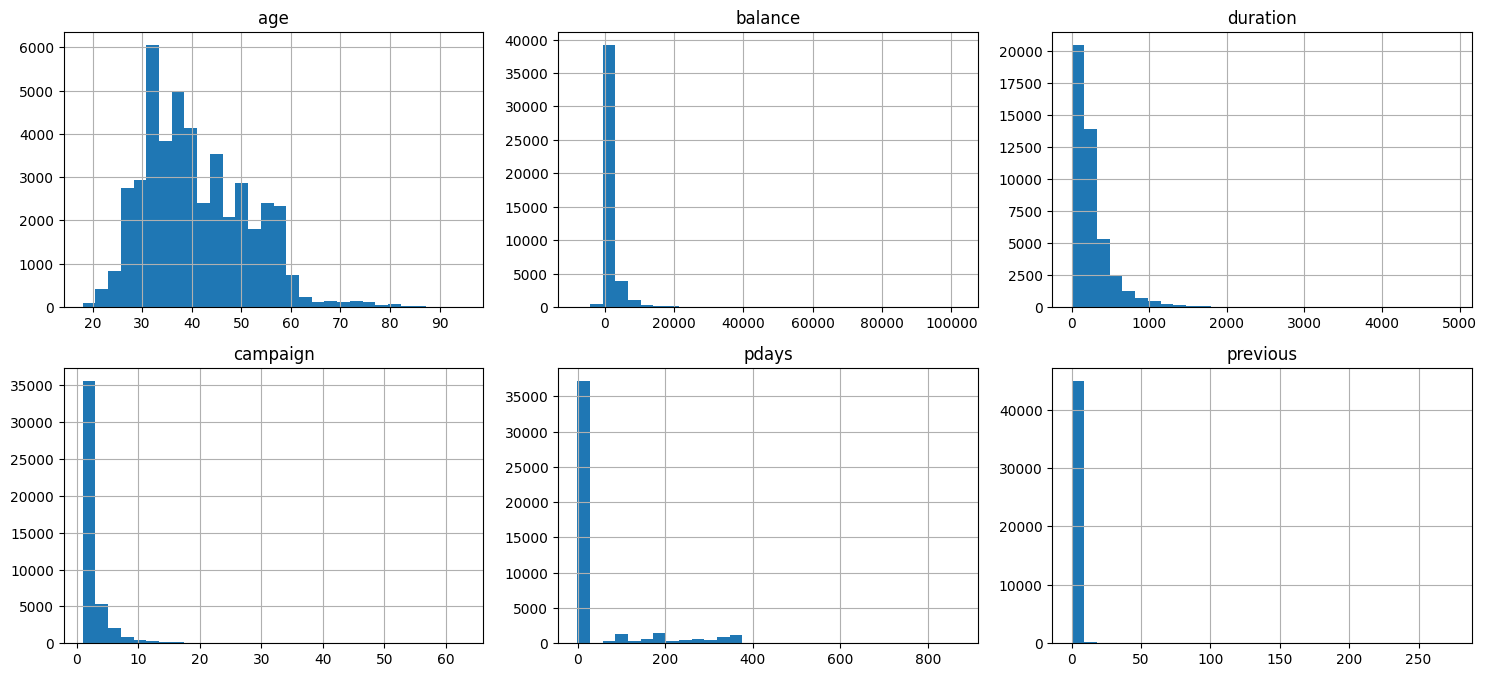

In [ ]:
import matplotlib.pyplot as plt

# Select numeric columns
num_cols = df.select_dtypes(include='number').columns

# drop last column as it's binary.
num_cols = num_cols[:-1]

# Plot histograms
df[num_cols].hist(bins=30, figsize=(15, 10), layout=(len(num_cols) // 3 + 1, 3))
plt.tight_layout()
plt.show()

In [ ]:
# All of these columns are right tailed so we will perform log transform on all of them.
# This prevents outliers from skewing the results.

# some care has to be taken with 'balance' because it has negative values.
# we employ the transform log1(x+a), where a is chosen such that x+a >= 0
# this gets around the log(x) being undefined for x <= 0 problem.


a = df['balance'].min()
df['balance_log'] = np.log1p(df['balance'] -a)
df['balance_log'].describe()

,balance_log
count,45211.000000
mean,9.118653
std,0.212975
min,0.000000
25%,8.998631
50%,9.044050
75%,9.153558
max,11.609571


In [ ]:
# remove 'balance' from the df and from the num_cols index after processing.

df.drop(columns=['balance'], inplace=True)
num_cols = num_cols.drop('balance')

In [ ]:
safe_cols = [col for col in num_cols if (df[col] > -1).all()]

In [ ]:
# apply log(x+1) transform for the safe columns

df[safe_cols] = np.log1p(df[safe_cols])

In [ ]:
# check which remaining num columns doesn't satisfy x > -1 for all x in df[col]

print(f'Columns still need processing: {set(num_cols).difference(set(safe_cols))}')

Columns still need processing: {'pdays'}


In [ ]:
# handle 'pday' with the -1 value for not contacted

# replace -1 with another constant outside the usual range. In this case 999.

df['pdays_clean'] = df['pdays'].replace(-1, 999)
df['pdays_log'] = np.log1p(df['pdays_clean'])

In [ ]:
# drop the pretransformed columns if they aren't needed for analysis.

df.drop(columns=['pdays_clean'], inplace=True)
df.drop(columns=['pdays'], inplace=True)

# Train / test split

I need to split the data before applying transforms. Otherwise, the anomalies will influence the scaling of the normal class.

Requirements of this split:

-No anomalies in the train set. This is a fully unsupervised learning-project.  
-The same porportion of anomalies to normal data as in the oringal dataset should be in the test set.


In [ ]:
yes_rows = targets['y'] == 'yes'
yes_df = df[yes_rows]
proportion = yes_df.shape[0] / df.shape[0]
print(f'Proportion of anomalies to total data: {100 * proportion:.5}%')

Proportion of anomalies to total data: 11.698%


In [ ]:
# Use a standard 80 train / 20 test split.

# Determine split sizes
n_test = round(0.20 * df.shape[0])
n_test_yes = round(n_test * proportion)

# Sample positive (yes) class for test set
yes_rows = df[targets['y'] == 'yes']
test_yes = yes_rows.sample(n=n_test_yes, random_state=42)

# Sample negative (no) class for test set
no_rows = df[targets['y'] == 'no']
n_test_no = n_test - n_test_yes
test_no = no_rows.sample(n=n_test_no, random_state=42)

# Create test set
test_df = pd.concat([test_yes, test_no])

# Create training set by dropping test rows
train_df = df.drop(test_df.index)
train_targets = targets.drop(test_df.index)
test_targets = targets.loc[test_df.index]

In [ ]:
train_targets

,y
0,no
2,no
3,no
5,no
6,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


In [ ]:
# convert targets to binary.

mapping = {'yes': 1, 'no': 0}
train_targets.replace(mapping, inplace=True)
test_targets.replace(mapping, inplace=True)

# One-hot encoding and scaling

I plan to use SVM which is a distance-based model so I have to use one-hot encoding.  
Otherwse the model might interpret distance between the categories as meaningful when it's actually just noise.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Define column types
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols.remove('prev_contact')  # Exclude boolean/binary column from scaling

cat_cols = df.select_dtypes(include='object').columns.tolist()

# Build the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ],
    remainder='passthrough'  # Keeps 'prev_contact' and any other unprocessed columns
)

# Apply the preprocessing
x_train = preprocessor.fit_transform(train_df)
x_test = preprocessor.fit_transform(test_df)

# Fit Support-vector machine

I'm treating this as an unsupervised anomaly detection problem so the idea is to fit a one-class SVM.  

This SVM will learn the boundaries of the normal class. Anything outside of this boundary will be treated as an anomaly.

In [ ]:
from sklearn.svm import OneClassSVM

model = OneClassSVM(
    kernel='rbf',      # radial basis function is the standard choice.
    gamma='scale',     # 'scale' is also default
    nu=0.11             # Approx. proportion of outliers expected.
)

In [ ]:
model.fit(x_train)              # Only normal data, no labels.
y_pred = model.predict(x_test) # Returns +1 for inliers, -1 for outliers

In [ ]:
# Convert -1 to 1 (anomaly), +1 to 0 (normal)
y_pred_binary = (y_pred == -1).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(test_targets, y_pred_binary))
print(classification_report(test_targets, y_pred_binary))

[[7245  739]
 [ 838  220]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      7984
           1       0.23      0.21      0.22      1058

    accuracy                           0.83      9042
   macro avg       0.56      0.56      0.56      9042
weighted avg       0.82      0.83      0.82      9042



In [ ]:
# try different hyperparameters.

model = OneClassSVM(
    kernel='rbf',
    gamma= 0.001,
    nu=0.11)

In [ ]:
model.fit(x_train)              #
y_pred = model.predict(x_test)
y_pred_binary = (y_pred == -1).astype(int)
print(confusion_matrix(test_targets, y_pred_binary))
print(classification_report(test_targets, y_pred_binary))

[[7272  712]
 [ 817  241]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      7984
           1       0.25      0.23      0.24      1058

    accuracy                           0.83      9042
   macro avg       0.58      0.57      0.57      9042
weighted avg       0.82      0.83      0.83      9042



# Hyperparameter search for gamma

In [ ]:
# from 1e-9 to 10
# num controls number of samples generated.

gamma_range = np.logspace(-9, 1, num = 20)

In [ ]:
# hyperparameter search with respect to gamma, fixing nu.
# we optimise with respect to f1-score for the anomaly class.

from sklearn.metrics import f1_score

best_gamma = None
best_f1 = -1

for gamma in gamma_range:
    model = OneClassSVM(kernel='rbf', gamma=gamma, nu=0.11)
    model.fit(x_train)

    preds = model.predict(x_test)
    # convert to 0 = normal, 1 = anomaly
    preds = np.where(preds == -1, 1, 0)

    f1 = f1_score(test_targets, preds)
    print(f'Gamma: {gamma:.1e} | F1: {f1:.4f}')

    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma

print(f'\nBest gamma: {best_gamma} | Best F1-score: {best_f1}')

Gamma: 1.0e-09 | F1: 0.2095
Gamma: 3.4e-09 | F1: 0.2245
Gamma: 1.1e-08 | F1: 0.2353
Gamma: 3.8e-08 | F1: 0.3030
Gamma: 1.3e-07 | F1: 0.2996
Gamma: 4.3e-07 | F1: 0.2340
Gamma: 1.4e-06 | F1: 0.2380
Gamma: 4.8e-06 | F1: 0.2406
Gamma: 1.6e-05 | F1: 0.2406
Gamma: 5.5e-05 | F1: 0.2406
Gamma: 1.8e-04 | F1: 0.2406
Gamma: 6.2e-04 | F1: 0.2397
Gamma: 2.1e-03 | F1: 0.2397
Gamma: 7.0e-03 | F1: 0.2418
Gamma: 2.3e-02 | F1: 0.2383
Gamma: 7.8e-02 | F1: 0.2202
Gamma: 2.6e-01 | F1: 0.2285
Gamma: 8.9e-01 | F1: 0.2700
Gamma: 3.0e+00 | F1: 0.2219
Gamma: 1.0e+01 | F1: 0.2120

Best gamma: 3.792690190732254e-08 | Best F1-score: 0.302960399846213


In [ ]:
# fit model with best parameter.

model = OneClassSVM(
    kernel='rbf',
    gamma= best_gamma,
    nu=0.11)

In [ ]:
model.fit(x_train)              #
y_pred = model.predict(x_test)
y_pred_binary = (y_pred == -1).astype(int)
print(confusion_matrix(test_targets, y_pred_binary))
print(classification_report(test_targets, y_pred_binary))

[[4628 3356]
 [ 270  788]]
              precision    recall  f1-score   support

           0       0.94      0.58      0.72      7984
           1       0.19      0.74      0.30      1058

    accuracy                           0.60      9042
   macro avg       0.57      0.66      0.51      9042
weighted avg       0.86      0.60      0.67      9042



# Hyperparameter search for nu

In [ ]:
nu_values = np.linspace(0.05, 0.15, 11)  # from 5% to 15% in steps of 1%

In [ ]:
best_nu = None
best_f1 = -1

for nu in nu_values:
    model = OneClassSVM(kernel='rbf', gamma=best_gamma, nu=nu)
    model.fit(x_train)

    preds = model.predict(x_test)
    preds = np.where(preds == -1, 1, 0)  # map -1 to anomaly class (1), +1 to normal (0)

    f1 = f1_score(test_targets, preds, pos_label=1)

    print(f"nu: {nu:.3f}, F1 (anomaly): {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_nu = nu

print(f"\nBest nu: {best_nu}, F1: {best_f1:.4f}")

nu: 0.050, F1 (anomaly): 0.2667
nu: 0.060, F1 (anomaly): 0.2770
nu: 0.070, F1 (anomaly): 0.1167
nu: 0.080, F1 (anomaly): 0.2759
nu: 0.090, F1 (anomaly): 0.3335
nu: 0.100, F1 (anomaly): 0.1815
nu: 0.110, F1 (anomaly): 0.3030
nu: 0.120, F1 (anomaly): 0.3037
nu: 0.130, F1 (anomaly): 0.3053
nu: 0.140, F1 (anomaly): 0.3027
nu: 0.150, F1 (anomaly): 0.3243

Best nu: 0.09, F1: 0.3335


In [ ]:
"""
because there was a sharp change in performance around the best nu,
it makes sense to keep searching in this region.

nu: 0.080, F1 (anomaly): 0.2759
nu: 0.090, F1 (anomaly): 0.3335 # best nu
nu: 0.100, F1 (anomaly): 0.1815
"""

nu_values = np.linspace(0.085, 0.095, num=11)

best_nu = None
best_f1 = -1

for nu in nu_values:
    model = OneClassSVM(kernel='rbf', gamma=best_gamma, nu=nu)
    model.fit(x_train)

    preds = model.predict(x_test)
    preds = np.where(preds == -1, 1, 0)  # map -1 to anomaly class (1), +1 to normal (0)

    f1 = f1_score(test_targets, preds, pos_label=1)

    print(f"nu: {nu:.3f}, F1 (anomaly): {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_nu = nu

print(f"\nBest nu: {best_nu}, F1: {best_f1:.4f}")

nu: 0.085, F1 (anomaly): 0.3053
nu: 0.086, F1 (anomaly): 0.2093
nu: 0.087, F1 (anomaly): 0.3192
nu: 0.088, F1 (anomaly): 0.3047
nu: 0.089, F1 (anomaly): 0.2937
nu: 0.090, F1 (anomaly): 0.3335
nu: 0.091, F1 (anomaly): 0.2824
nu: 0.092, F1 (anomaly): 0.3019
nu: 0.093, F1 (anomaly): 0.2929
nu: 0.094, F1 (anomaly): 0.3068
nu: 0.095, F1 (anomaly): 0.2853

Best nu: 0.09, F1: 0.3335


# Evaluate the final model

In [ ]:
model = OneClassSVM(
    kernel='rbf',      # radial basis function is the standard choice.
    gamma=best_gamma,
    nu=best_nu
)

model.fit(x_train)              #
y_pred = model.predict(x_test)
y_pred_binary = (y_pred == -1).astype(int)
print(confusion_matrix(test_targets, y_pred_binary))
print(classification_report(test_targets, y_pred_binary))

[[6464 1520]
 [ 542  516]]
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7984
           1       0.25      0.49      0.33      1058

    accuracy                           0.77      9042
   macro avg       0.59      0.65      0.60      9042
weighted avg       0.84      0.77      0.80      9042

